In [4]:
# pip install -r requirements.txt

# Importing libraries

import os
import shutil
import random
from PIL import Image
import torch
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from torchvision import models, transforms
from torchvision.utils import save_image
import numpy as np
import hdbscan
import matplotlib.gridspec as gridspec
from IPython.display import display
from kneed import KneeLocator
import kagglehub
from itertools import product
import warnings
from matplotlib.colors import ListedColormap
import joblib
import pandas as pd

In [5]:
# ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
# Define main directories
folders = {
    "data_full": ["raw"],
    "data_sample": ["preprocessed_images", "raw"]
}

# Create directories if they don't exist
for main_folder, subfolders in folders.items():
    os.makedirs(main_folder, exist_ok=True)
    for subfolder in subfolders:
        os.makedirs(os.path.join(main_folder, subfolder), exist_ok=True)

In [7]:
# Check if the dataset is already downloaded
if len(os.listdir("data_full/raw")) == 0:
    
    print("Downloading dataset...")
    # Define paths
    download_dir = os.path.join("data_full", "raw")
    os.makedirs(download_dir, exist_ok=True)

    # Download dataset
    path = kagglehub.dataset_download("steubk/wikiart", path=download_dir)

    def flatten_directory(directory):
        # Move all files from subdirectories to parent directory and delete subdirs
        for root, dirs, files in os.walk(directory, topdown=False):
            # Skip the parent directory itself
            if root == directory:
                continue
                
            for file in files:
                src_path = os.path.join(root, file)
                dest_path = os.path.join(directory, file)
                
                # Handle potential filename conflicts
                if os.path.exists(dest_path):
                    base, extension = os.path.splitext(file)
                    counter = 1
                    # Generate unique filename by appending _n
                    while os.path.exists(dest_path):
                        new_name = f"{base}_{counter}{extension}"
                        dest_path = os.path.join(directory, new_name)
                        counter += 1
                        
                shutil.move(src_path, dest_path)
            
            # Remove the emptied directory
            shutil.rmtree(root)

    # Flatten the directory structure
    flatten_directory(download_dir)
    print(f"All {len(os.listdir('data_full/raw'))} files consolidated in: {download_dir}")

elif len(os.listdir("data_full/raw")) < 81446:
    raise Exception("The dataset is not complete")

else:
    print(f"Dataset already downloaded with {len(os.listdir('data_full/raw'))} images")

Dataset already downloaded with 81446 images


In [8]:
def ensure_flat_directory(directory):
    # Check for subdirectories and flatten if needed
    # Check if any subdirectories exist
    has_subdirs = any(os.path.isdir(os.path.join(directory, item)) 
                    for item in os.listdir(directory))
    
    if has_subdirs:
        print("Subdirectories detected - flattening structure...")
        flatten_directory(directory)
    else:
        print("No subdirectories detected - structure already flat")

def flatten_directory(directory):
    # Flatten directory structure by moving all files to root
    for root, dirs, files in os.walk(directory, topdown=False):
        # Skip the root directory itself
        if root == directory:
            continue
            
        for file in files:
            src = os.path.join(root, file)
            dst = os.path.join(directory, file)
            
            # Handle duplicates
            if os.path.exists(dst):
                base, ext = os.path.splitext(file)
                counter = 1
                while os.path.exists(dst):
                    new_name = f"{base}_{counter}{ext}"
                    dst = os.path.join(directory, new_name)
                    counter += 1
                    
            shutil.move(src, dst)
        
        # Remove emptied directory
        if os.path.exists(root):
            shutil.rmtree(root)

def create_sample_dataset(source_dir, dest_dir, n):
    # Create sample dataset with n random files
    # Get all files after flattening
    all_files = [f for f in os.listdir(source_dir) 
                 if os.path.isfile(os.path.join(source_dir, f))]
    
    # Create destination
    os.makedirs(dest_dir, exist_ok=True)
        
    # Copy random sample
    sample_counter = 0
    for file in random.sample(all_files, n):
        src = os.path.join(source_dir, file)
        dst = os.path.join(dest_dir, file)
        shutil.copy2(src, dst)
        sample_counter += 1
        if sample_counter % 500 == 0:
            print(f"{sample_counter} files copied to sample dataset")
        return dest_dir

def handle_existing_files(directory):
    preprocessed_dir = os.path.join("data_sample", "preprocessed_images")
    if (os.path.exists(directory) and os.listdir(directory)) or (os.path.exists(preprocessed_dir) and os.listdir(preprocessed_dir)):
        choice = input(f"Files already exist in {directory}. Do you want to (S)kip or (D)elete and create new? ").strip().lower()
        if choice == 'd':
            shutil.rmtree(directory)
            os.makedirs(directory, exist_ok=True)
            print("Existing files in raw deleted. Creating new sample dataset...")
            if os.path.exists(preprocessed_dir):
                shutil.rmtree(preprocessed_dir)
                os.makedirs(preprocessed_dir, exist_ok=True)
                print("Existing files in preprocessed_images deleted.")
        elif choice == 's':
            print("Skipping sample dataset creation.")
            return False
    return True

# Main execution flow
if __name__ == "__main__":
    # Setup paths
    raw_dir = os.path.join("data_full", "raw")
    sample_dir = os.path.join("data_sample", "raw")
    
    # Ensure flat structure
    ensure_flat_directory(raw_dir)
    
    # Create sample dataset
    if handle_existing_files(sample_dir) == True:
        try:
            n = int(input(f"How many sample images do you want to create? \nFor reference, the full dataset has {len(os.listdir("data_full/raw"))} images. "))
            if n > len(os.listdir("data_full/raw")):
                n = len(os.listdir("data_full/raw"))
                print(f"Sample size exceeds the full dataset size. Using full data of size: {len(os.listdir("data_full/raw"))}")
                sampled_dir = r"data_full/raw"
            elif n < len(os.listdir("data_full/raw")):
                print(f"Creating sample dataset with {n} images...")
                sampled_dir = create_sample_dataset(raw_dir, sample_dir, n)
        except ValueError:
            print("Invalid input. Please enter a number.")
        print(f"Sample dataset created with {n} files from {raw_dir} to {sampled_dir}")
    else:
        sampled_dir = r"data_full/raw"
        print(f"Using full data of size: {len(os.listdir("data_full/raw"))}")

No subdirectories detected - structure already flat
Skipping sample dataset creation.
Using full data of size: 81446


In [9]:
# Define paths
input_dir = f"{sampled_dir}"
output_dir = r"data_sample\preprocessed_images"

os.makedirs(output_dir, exist_ok=True)

# Get counts of images in raw and preprocessed directories
raw_images = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
preprocessed_images = [f for f in os.listdir(output_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if len(raw_images) == len(preprocessed_images):
    print("Skipping preprocessing: All images are already preprocessed.")
elif len(preprocessed_images) <= 0:
    print("Preprocessing images...")
    preprocess_counter = 0

    
    # Define the image preprocessing transformations.
    preprocess = transforms.Compose([
        transforms.Resize(256), # Resize: Resize the image to 256x256 pixels.
        transforms.CenterCrop(224),  # CenterCrop: Crop the center 224x224 pixels.
        transforms.ToTensor(), # ToTensor: Convert the PIL image to a PyTorch tensor.
    ])

    for file in raw_images:
        img_path = os.path.join(input_dir, file)
        output_path = os.path.join(output_dir, file)
        preprocess_counter += 1
        if preprocess_counter % 500 == 0:
            print(f"{preprocess_counter} images preprocessed")
        try:
            img = Image.open(img_path).convert("RGB") # Open the image and convert to RGB.
            img_tensor = preprocess(img) # Apply the preprocessing transformations.
            save_image(img_tensor, output_path) # Save the preprocessed image.
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    print("Preprocessing completed.")
else:
    raise Exception("Sampling error: Number of preprocessed images does not match raw images. Please re-run the sampling process.")

Skipping preprocessing: All images are already preprocessed.


Randomly selected image: pyotr-konchalovsky_landscape-against-the-sun-1935.jpg


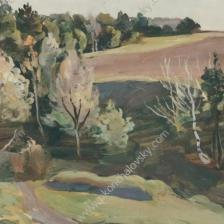

Min/Max pixel value: tensor(0.0784) tensor(0.8745)
Tensor shape: torch.Size([3, 224, 224])


In [10]:
# List all files in the directory
files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]

# Filter for image files
image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

if image_files:
    random_image = random.choice(image_files)
    test_img = Image.open(os.path.join(output_dir, random_image))
    print(f"Randomly selected image: {random_image}")
    display(test_img)
    test_tensor = transforms.ToTensor()(test_img)
    print("Min/Max pixel value:", test_tensor.min(), test_tensor.max())
else:
    print("No images found.")

print("Tensor shape:", test_tensor.shape)  # Should be (3, 224, 224)

In [ ]:
# Convert images to embeddings.

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

# Correct transform without Resize/Crop
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Reload image files from output directory
output_dir = r"data_sample\preprocessed_images"
files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]
image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# Extract embeddings
embeddings = []
embedding_counter = 0
print("Extracting embeddings...")
for file in image_files: # Loop through all image files
    img_path = os.path.join(output_dir, file) # Get full path to image
    embedding_counter += 1
    if embedding_counter % 500 == 0:
        print(f"Processed {embedding_counter} images")
    try:
        image = Image.open(img_path).convert("RGB") # Open image and convert to RGB
        image_tensor = transform(image).unsqueeze(0) # Apply transform and add batch dimension
        with torch.no_grad(): # Extract embedding without computing gradients (for efficiency)
            embedding = model(image_tensor)

        # Convert the embedding tensor to a NumPy array and store it    
        embedding = embedding.squeeze().cpu().numpy()
        embeddings.append(embedding)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

print("Embeddings extracted.")

Extracting embeddings...
Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images
Processed 4500 images
Processed 5000 images
Processed 5500 images
Processed 6000 images
Processed 6500 images
Processed 7000 images
Processed 7500 images
Processed 8000 images
Processed 8500 images
Processed 9000 images
Processed 9500 images
Processed 10000 images
Processed 10500 images


In [ ]:
# Ensure conversion to NumPy array
embeddings_array = np.array(embeddings)
print("Embeddings shape:", embeddings_array.shape)

# Save embeddings to file
np.save('embeddings.npy', embeddings_array)
print("Embeddings saved to embeddings.npy")

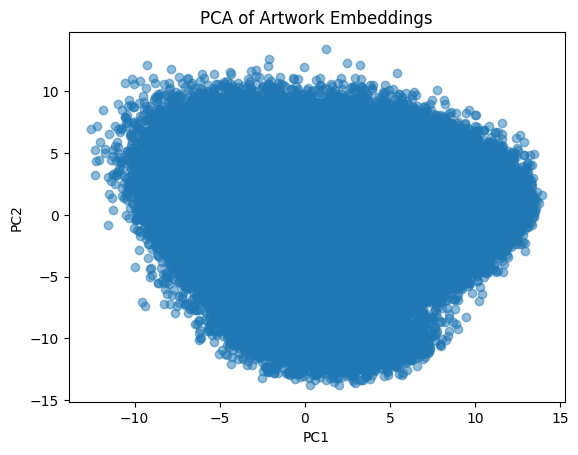

In [ ]:
# EDA

# Load embeddings from file
embeddings = np.load('embeddings.npy')
print("Embeddings proprely loaded. Embeddings shape:", embeddings_array.shape)

# Reduce embeddings to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title("PCA of Artwork Embeddings")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

c:\Users\RohanGupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


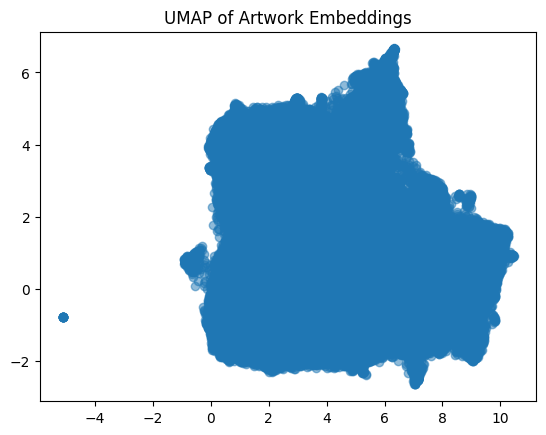

In [ ]:
# Dimensionality Reduction

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15, 
    min_dist=0.1,    # Control cluster tightness
)
embeddings_umap = reducer.fit_transform(embeddings)
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], alpha=0.5)
plt.title("UMAP of Artwork Embeddings")
plt.show()

In [ ]:
# Tune k hyperparameter for KMeans clustering
k_values = range(7, 13) # domain knowledge suggests 8-12 clusters, less than 7 is unusable
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

# Find optimal k (highest score) greater than 7
optimal_k = 8  # Default to 8 if no suitable k is found
best_score = -1  # Initialize with a value lower than any possible silhouette score

for i, score in enumerate(silhouette_scores):
    k = k_values[i]
    if k > 7 and score > best_score:
        best_score = score
        optimal_k = k

print(f"\nOptimal k (greater than 7): {optimal_k}")

k=3: Silhouette Score = 0.0686
k=4: Silhouette Score = 0.0594
k=5: Silhouette Score = 0.0557
k=6: Silhouette Score = 0.0411
k=7: Silhouette Score = 0.0412
k=8: Silhouette Score = 0.0392
k=9: Silhouette Score = 0.0401
k=10: Silhouette Score = 0.0383
k=11: Silhouette Score = 0.0333
k=12: Silhouette Score = 0.0260
k=13: Silhouette Score = 0.0267
k=14: Silhouette Score = 0.0272
k=15: Silhouette Score = 0.0278

Optimal k (greater than 7): 9


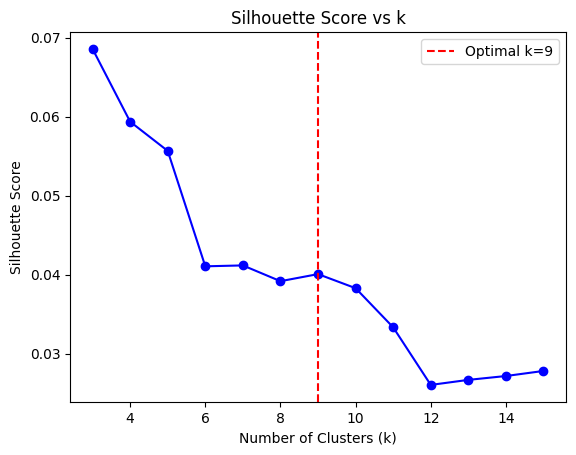

In [ ]:
# Create silhouette plot
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f"Optimal k={optimal_k}")
plt.legend()
plt.show()

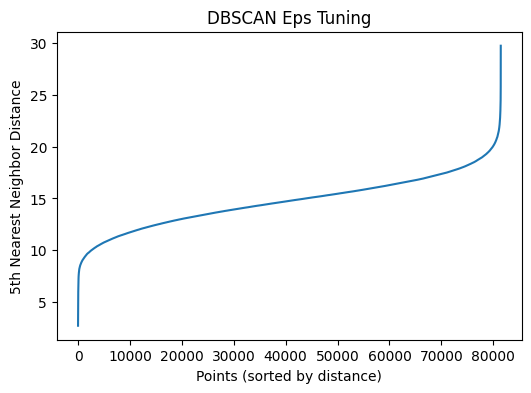

In [ ]:
# Tune eps using nearest neighbors distance plot

# Compute 5th-nearest-neighbor distances
nn = NearestNeighbors(n_neighbors=5)
nn.fit(embeddings)
distances, _ = nn.kneighbors(embeddings)

# Sort the 5th-nearest-neighbor distances
distances = np.sort(distances[:, -1])

#  Plot the distances
plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.xlabel("Points (sorted by distance)")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("DBSCAN Eps Tuning")
plt.show()

In [ ]:
kneedle = KneeLocator(
    x=range(len(distances)),   # Index array
    y=distances,               # Sorted distances
    curve='convex',            
    direction='increasing'     
)

# The knee attribute is the index of the knee in the x-array
knee_index = kneedle.knee
print(f"Knee index: {knee_index}")

# The actual distance value at the knee can be used as eps
if knee_index is not None:
    eps_value = distances[knee_index]
    print(f"Recommended eps: {eps_value}")
else:
    eps_value = 5.0  # Fallback
    print("Could not find a clear knee; using a fallback eps of 5.0.")

Knee index: 81267
Recommended eps: 22.329591751098633


In [ ]:
# Create a DBSCAN clustering object.
# eps: Radius around a point to search for neighbors.
# min_samples: Minimum number of neighbors for a point to be a core point.
dbscan = DBSCAN(eps=eps_value, min_samples=5)

# Perform DBSCAN clustering and get cluster labels.
# db_labels: Array of cluster assignments for each embedding. -1 means noise.
db_labels = dbscan.fit_predict(embeddings)


print(f"Unique clusters: {np.unique(db_labels)}")

NameError: name 'eps_value' is not defined

In [ ]:
# Create an HDBSCAN clustering object.

hdb = hdbscan.HDBSCAN(
    min_cluster_size=3,      # Smaller clusters allowed (default=5)
    min_samples=1,           # Fewer neighbors to define core points
    cluster_selection_epsilon=0.1,  # Merge nearby clusters
    gen_min_span_tree=True   # For diagnostics
)

# Perform HDBSCAN clustering and get cluster labels.
hdb_labels = hdb.fit_predict(embeddings)
print(f"Unique clusters: {np.unique(hdb_labels)}")

In [ ]:
# Hyperparameter tuning for dbscan and hdbscan

# Define parameter ranges
dbscan_eps_values = eps_value
dbscan_min_samples_values = [3, 5, 10]

hdb_min_cluster_size_values = [3, 5, 10]
hdb_min_samples_values = [3, 5, 10]
hdb_cluster_selection_epsilon_values = [0.0, 0.1, 0.2]

# Function to evaluate clustering with silhouette score
def evaluate_clustering(labels, embeddings):
    unique_clusters = set(labels)
    
    # Silhouette score requires at least 2 clusters and cannot have only noise (-1)
    if len(unique_clusters) > 1 and -1 not in unique_clusters:
        return silhouette_score(embeddings, labels)
    
    return -1  # Invalid clustering

# Hyperparameter tuning for DBSCAN
best_dbscan_score = -1
best_dbscan_params = (eps_value, 5)  # Default values

print("Tuning DBSCAN hyperparameters...")
for min_sample in (dbscan_min_samples_values):
    dbscan = DBSCAN(eps=eps_value, min_samples=min_sample)
    labels = dbscan.fit_predict(embeddings)
    
    sil_score = evaluate_clustering(labels, embeddings)
    
    if sil_score > best_dbscan_score:
        best_dbscan_score = sil_score
        best_dbscan_params = (eps_value, min_sample)
if best_dbscan_params == (eps_value, 5):
    print(f"Default DBSCAN Params: eps={best_dbscan_params[0]}, min_samples={best_dbscan_params[1]}, silhouette={best_dbscan_score:.4f}\nDBSCAN did not find any better clusters with the given hyperparameter ranges.")
elif best_dbscan_params:
    print(f"Best DBSCAN Params: eps={best_dbscan_params[0]}, min_samples={best_dbscan_params[1]}, silhouette={best_dbscan_score:.4f}")
else:
    print("DBSCAN did not find any valid clusters with the given hyperparameter ranges.")

# Hyperparameter tuning for HDBSCAN
best_hdbscan_score = -1
best_hdbscan_params = (3, 5, .1) # Default values

print("Tuning HDBSCAN hyperparameters...")
for min_cluster_size, min_samples, epsilon in product(
        hdb_min_cluster_size_values, hdb_min_samples_values, hdb_cluster_selection_epsilon_values):
    
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=epsilon,
        gen_min_span_tree=True
    )
    
    labels = hdb.fit_predict(embeddings)
    
    sil_score = evaluate_clustering(labels, embeddings)
    
    if sil_score > best_hdbscan_score:
        best_hdbscan_score = sil_score
        best_hdbscan_params = (min_cluster_size, min_samples, epsilon)

if best_hdbscan_params == (3, 1, .1):
    print(f"Default HDBSCAN Params: min_cluster_size={best_hdbscan_params[0]}, min_samples={best_hdbscan_params[1]}, epsilon={best_hdbscan_params[2]}, silhouette={best_hdbscan_score:.4f}\nHDBSCAN did not find any better clusters with the given hyperparameter ranges.")
elif best_hdbscan_params:
    print(f"Best HDBSCAN Params: min_cluster_size={best_hdbscan_params[0]}, min_samples={best_hdbscan_params[1]}, epsilon={best_hdbscan_params[2]}, silhouette={best_hdbscan_score:.4f}")
else:
    print("HDBSCAN did not find any valid clusters with the given hyperparameter ranges.")


In [ ]:
# For K-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(embeddings)

cmap = plt.colormaps.get_cmap('tab20')
colors = ListedColormap(cmap(range(optimal_k)))

scatter = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
            c=kmeans_labels, cmap=colors, alpha=0.6)  # Store the scatter plot object

plt.title(f"UMAP Visualization with K-means Clusters (k ={optimal_k})")


cbar = plt.colorbar(scatter)  # Get the colorbar associated with the scatter plot
cbar.set_ticks(np.arange(optimal_k))  # Set the ticks to the cluster labels
cbar.set_ticklabels(np.arange(optimal_k)) # Set the tick labels to the cluster labels

plt.show()

In [ ]:
# For DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=best_dbscan_params[1])
db_labels = dbscan.fit_predict(embeddings)

unique_labels = np.unique(db_labels)  # Get the unique labels (including -1 for noise)
num_clusters = len(unique_labels)

cmap = plt.colormaps.get_cmap('tab20')
colors_db = ListedColormap(cmap(range(num_clusters)))

scatter_db = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                        c=db_labels, cmap=colors_db, alpha=0.6)
plt.title(f"UMAP Visualization with DBSCAN Clusters")

cbar_db = plt.colorbar(scatter_db)

# Improved colorbar handling for DBSCAN (handling -1 for noise)
cbar_db.set_ticks(np.arange(num_clusters))
cbar_db.set_ticklabels(unique_labels) # Use the actual cluster labels, including -1

plt.show()

In [ ]:
# For HDBSCAN
hdb = hdbscan.HDBSCAN(
    min_cluster_size=best_hdbscan_params[0],
    min_samples=best_hdbscan_params[1],
    cluster_selection_epsilon=best_hdbscan_params[2],
    gen_min_span_tree=True  # For diagnostics
)
hdb_labels = hdb.fit_predict(embeddings)

unique_hdb_labels = np.unique(hdb_labels)
num_hdb_clusters = len(unique_hdb_labels)

cmap = plt.colormaps.get_cmap('tab20')
colors_hdb = ListedColormap(cmap(range(num_hdb_clusters)))

scatter_hdb = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1],
                        c=hdb_labels, cmap=colors_hdb, alpha=0.6)
plt.title(f"UMAP Visualization with HDBSCAN Clusters")

cbar_hdb = plt.colorbar(scatter_hdb)

# Improved colorbar handling for HDBSCAN (handling -1 for noise)
cbar_hdb.set_ticks(np.arange(num_hdb_clusters))
cbar_hdb.set_ticklabels(unique_hdb_labels)  # Use the actual cluster labels, including -1

plt.show()

In [ ]:
# Compare models using Silhouette Score
print("K-means Silhouette:", silhouette_score(embeddings, kmeans_labels))
print("HDBSCAN Silhouette:", silhouette_score(embeddings, hdb_labels))
print("DBSCAN Silhouette:", silhouette_score(embeddings, db_labels))

In [ ]:
def plot_cluster_samples(labels, n_samples=6):
    """
    Plots a set of sample images from each cluster.

    Parameters:
    labels (array-like): Array of cluster labels corresponding to images.
    n_samples (int, optional): Number of samples to display per cluster. Default is 6.
    """
    unique_labels = np.unique(labels)  # Get unique cluster labels
    
    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]  # Find indices of images in the current cluster
        
        if len(cluster_indices) == 0:  # Skip empty clusters
            continue
        
        # Randomly select up to `n_samples` images from the cluster
        samples = np.random.choice(cluster_indices, min(n_samples, len(cluster_indices)), replace=False)
        
        # Create a figure to display the selected images
        plt.figure(figsize=(15, 3))
        gs = gridspec.GridSpec(1, n_samples)  # Define a grid layout for images
        
        for i, idx in enumerate(samples):
            ax = plt.subplot(gs[i])  # Create a subplot for each sample
            
            # Load and display the image
            img = Image.open(os.path.join(output_dir, image_files[idx]))
            ax.imshow(img)
            ax.axis('off')  # Remove axis labels for a cleaner look
        
        plt.suptitle(f"Cluster {label} Samples")  # Set the title for the cluster
        plt.show()  # Display the figure

In [ ]:
plot_cluster_samples(kmeans_labels)

In [ ]:
plot_cluster_samples(hdb_labels)

In [ ]:
plot_cluster_samples(db_labels)

In [ ]:
# Save the trained KMeans model to a file named "kmeans_model.pkl" in the current directory.

joblib.dump(kmeans, "kmeans_model.pkl")  # Save to project root

In [ ]:
# Create a dataframe mapping filenames to clusters

cluster_df = pd.DataFrame({
    "filename": image_files,
    "cluster": kmeans_labels
})

# Save to CSV
cluster_df.to_csv("cluster_assignments.csv", index=False)